In [115]:
import json
import nltk
import re
import itertools
from time import sleep
import sys
import numpy
import scipy
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from collections import Counter
with open("proj1_data.json") as fp:
    data = json.load(fp)

In [116]:
# word count, no removal of punctuations
# @Param: singleText: text to process, numberOfFeatures: 0, 60, 160?
# @Return: vector of count (x in description)
def wordCountNaive(singleText, numberOfFeatures): 
    countNaive = Counter([s.lower() for s in singleText.split()])
    
    i = 0
    returnVector = [0.0 for i in range(0, numberOfFeatures)]
    for key, value in countNaive.most_common(numberOfFeatures): 
        if i == numberOfFeatures: 
            break
        returnVector[i] = float(value)
        i = i + 1
        
    return returnVector


# word count, remove punc and stopwords to imporve model
# @Param: singleText: text to process, numberOfFeatures: 0, 60, 160?
# @Return: vector of count (x in description)
def wordCountWithStopwords(singleText, numberOfFeatures): 
    
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(singleText)
    countDict = Counter(s.lower() for s in withoutPunc if s.lower() not in stopwords.words())
    
    i = 0
    returnVector = [0.0 for i in range(0, numberOfFeatures)]
    for key, value in countDict.most_common(numberOfFeatures): 
        if i == numberOfFeatures: 
            break
        returnVector[i] = float(value)
        i = i + 1

    return returnVector

# Test: 
# print(wordCountWithStopwords([data[8]['text']], 160))
# print(data[8]['text'])

In [117]:
# word pos count, remove punc and stopwords to imporve model
# @Param: singleText: text to process
# @Return: vector of [verbcount, nouncount, adjcount]
def wordPOSCountWithStopwords(singleText): 
    
    tokenizer = RegexpTokenizer(r'\w+')
    withoutPunc = tokenizer.tokenize(singleText)
    tagged = nltk.pos_tag([s.lower() for s in withoutPunc if s.lower() not in stopwords.words()])
    
    verbTotal, nounTotal, adjTotal = 0, 0, 0
    counts = Counter(tag for wordType, tag in tagged)
    totalCount = len(singleText.split())
    
    for key, value in counts.items(): 
        if 'NN' in key: 
            nounTotal = nounTotal + 1
        elif 'VB' in key: 
            verbTotal = verbTotal + 1
        elif 'JJ' in key: 
            adjTotal = adjTotal + 1
            
    if totalCount > 0: 
        return [float(verbTotal) / totalCount, float(nounTotal) / totalCount, float(adjTotal) / totalCount]
    else: 
        return [0.0, 0.0, 0.0]
# Test: 
# print(wordPOSCountWithStopwords(data[3]['text']))
# print(data[3]['text'])

In [118]:
def hasURL(text): 
    if re.match(r"(http://[^ ]+)", text) != None: 
        return 1.0
    else: 
        return 0.0

In [119]:
def pythonListTranspose(xl): 
    return list(map(list, itertools.zip_longest(*xl)))

In [232]:
# Feature Parser
# @Param: dataVector: sliced original dataset, wordCountFunction: <str> -> ndarray<float>, 
# wordPOSFunction: str -> list<float>, numberOfTextFeature: 0 to shut down Text Processing (Text Features)
# featureType: 
# @Return: tuple<ndarray, list>: xEngineered, yExtracted: rows: vector<samplePoint>, samplePoint[0->2]: basic Features, 
# samplePoint[3->162]: text, samplePoint[163->167]: extra
def parseFeatures(dataVector, wordCountFunction, numberOfTextFeatures, featureType): 
    y = []
    childrenFeature = []
    controversialityFeature = []
    isRootFeature = []
    processedTextFeature = []
    verbFeature = []
    nounFeature = []
    adjFeature = []
    urlFeature = []
    identityFeature = []
    c = 0
    lenV = len(dataVector)
    for dataPoint in dataVector: 
        
        # Basic Features
        y.append(float(dataPoint['popularity_score']))
        if 'children' in featureType: 
            childrenFeature.append(float(dataPoint['children']))
        if 'controv' in featureType: 
            controversialityFeature.append(float(dataPoint['controversiality']))
        identityFeature.append(1.0)
        isRootVar = -1.0
        if 'isRoot' in featureType: 
            if dataPoint['is_root'] == True: 
                isRootVar = 1.0
                isRootFeature.append(isRootVar)
            else: 
                isRootVar = 0.0
                isRootFeature.append(isRootVar)
        
        # Text Features: 0 to shut down text feature
        if numberOfTextFeatures > 0 and 'text' in featureType: 
            processedTextFeature.append(wordCountFunction(dataPoint['text'], numberOfTextFeatures))
        
        # Extra Features
        if 'noun' in featureType or 'verb' in featureType or 'adj' in featureType: 
            wordAnalysis = wordPOSCountWithStopwords(dataPoint['text'])
        if 'verb' in featureType: 
            verbFeature.append(wordAnalysis[0])
        if 'noun' in featureType: 
            nounFeature.append(wordAnalysis[1])
        if 'adj' in featureType: 
            adjFeature.append(wordAnalysis[2])
        if 'url' in featureType: 
            urlFeature.append(hasURL(dataPoint['text']))
        
        # Process Bar
        sys.stdout.write('\r')
        count = int((float(c) / float(lenV)) * 100)
        sys.stdout.write("[%-20s] %d%%" % ('='*int(count / 5), count))
        sleep(0.001)
        sys.stdout.flush()
        c = c + 1
    if len(processedTextFeature) > 0: 
        processedTextFeature = pythonListTranspose(processedTextFeature)
    returnTotal = [childrenFeature, controversialityFeature, isRootFeature] + processedTextFeature + [verbFeature, nounFeature, adjFeature, urlFeature, identityFeature]
    return pythonListTranspose([x for x in returnTotal if len(x) > 0]), pythonListTranspose([y])

In [233]:
def meanSquareError(validationX, validationY, w): 
    diffenence = numpy.power(numpy.transpose(numpy.subtract(validationY, numpy.matmul(validationX, w)))[0], 2)
    return numpy.divide(numpy.sum(diffenence), len(validationY))

In [234]:
def closedFormLinearRegression(x, y): 
    xT = numpy.transpose(numpy.array(x))
    return numpy.matmul(numpy.matmul(scipy.linalg.inv(numpy.matmul(xT, numpy.array(x))), xT), numpy.array(y))

In [235]:
def gradientDescentLinearRegression(learnRateFunction, x, y, tol): 
    i = 1
    weight = numpy.array([[0.0] for l in range(len(x[0]))])
    weightN = numpy.array([[0.0] for l in range(len(x[0]))])
    xT = numpy.transpose(x)
    xTx = numpy.matmul(xT, x)
    xTy = numpy.matmul(xT, y)
    while True: 
        weight = weightN
        weightN = numpy.subtract(weight, 2 * learnRateFunction(i) * numpy.subtract(numpy.matmul(xTx, weight), xTy))
        i = i + 1
        if numpy.linalg.norm(numpy.subtract(weightN, weight), 2) <= tol: 
            break
    return weightN


## Experiment 1: comparison of GD and closed form

In [219]:
trainFeatures = parseFeatures(data[:10000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])
validationFeatures = parseFeatures(data[10000:11000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])
testFeatures = parseFeatures(data[11000:12000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])

[=================== ] 99%

### Closed form

In [224]:
resultClosed = closedFormLinearRegression(trainFeatures[0], trainFeatures[1])
errorClosed = meanSquareError(validationFeatures[0], validationFeatures[1], resultClosed)
print('result of closed form: \n', resultClosed)
print('error of closed form: \n', errorClosed)

result of closed form: 
 [[ 0.37536403]
 [-1.08584747]
 [-0.22627679]
 [ 0.82092517]]
error of closed form: 
 1.0203266848431447


### Gradient Descent

In [225]:
resultGradient = gradientDescentLinearRegression(lambda v: float(0.0020 / (float(v) + 7.0)), trainFeatures[0], trainFeatures[1], 0.00000005)
errorGradient = meanSquareError(validationFeatures[0], validationFeatures[1], resultGradient)
print('result of gradient descent: \n', resultGradient)
print('error of gradient descent: \n', errorGradient)

result of gradient descent: 
 [[ 0.37533109]
 [-1.07323872]
 [-0.22619048]
 [ 0.8207526 ]]
error of gradient descent: 
 1.020380306032347


同志们 在上面的学习率上做文章 runtime或者error做个plot 变上面根本算不完 变下面会改变第二个参数的精度

## Experiment 2: Text features

In [238]:
trainFeatures60 = parseFeatures(data[:10000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'text'])
trainFeatures160 = parseFeatures(data[:10000], wordCountNaive, 160, ['children', 'controv', 'isRoot', 'text'])

[=================== ] 99%

In [243]:
validationFeatures60 = parseFeatures(data[10000:11000], wordCountNaive, 60, ['children', 'controv', 'isRoot', 'text'])
validationFeatures160 = parseFeatures(data[10000:11000], wordCountNaive, 160, ['children', 'controv', 'isRoot', 'text'])
testFeatures = parseFeatures(data[11000:12000], wordCountNaive, 0, ['children', 'controv', 'isRoot'])

[=================== ] 99%

### 60 text features

In [244]:
resultClosed = closedFormLinearRegression(trainFeatures60[0], trainFeatures60[1])
errorClosed = meanSquareError(validationFeatures60[0], validationFeatures60[1], resultClosed)
print('result of closed form: \n', resultClosed)
print('error of closed form: \n', errorClosed)

result of closed form: 
 [[ 3.74695111e-01]
 [-1.07354143e+00]
 [-2.16278073e-01]
 [-3.74625972e-02]
 [ 3.35057173e-02]
 [ 5.42286919e-02]
 [-4.65511800e-03]
 [ 3.52655606e-02]
 [ 3.67568792e-02]
 [-2.36741535e-03]
 [-3.32498864e-02]
 [ 3.38107071e-02]
 [-6.57306126e-02]
 [ 8.40728202e-02]
 [-2.57365907e-02]
 [-3.48272242e-04]
 [-1.35075864e-01]
 [ 5.51683049e-02]
 [ 9.14630439e-02]
 [ 2.20669528e-02]
 [ 4.49629169e-02]
 [-1.34218588e-01]
 [ 4.79114561e-02]
 [-1.04406934e-02]
 [ 1.95238650e-01]
 [-2.59536564e-01]
 [-5.80273190e-02]
 [ 4.40873129e-02]
 [ 2.66166704e-03]
 [-1.55967309e-01]
 [ 3.36928714e-01]
 [ 1.34490483e-02]
 [-3.01344520e-01]
 [ 2.66384375e-01]
 [-3.25259178e-01]
 [ 3.43536255e-01]
 [-1.95814207e-01]
 [-2.68266288e-02]
 [ 2.29292745e-01]
 [ 1.31799879e-01]
 [-4.30661088e-01]
 [ 1.25336300e-02]
 [ 3.28200816e-01]
 [-2.69265890e-02]
 [-4.84179116e-01]
 [-1.14722496e-01]
 [ 2.63881844e-01]
 [-3.94260506e-02]
 [-8.67481750e-02]
 [ 2.40714213e-01]
 [-4.27759819e-02]
 [ 2.1

In [262]:
resultClosed160 = closedFormLinearRegression(trainFeatures160[0], trainFeatures160[1])
errorClosed160 = meanSquareError(validationFeatures160[0], validationFeatures160[1], resultClosed160)
print('result of closed form: \n', resultClosed160)
print('error of closed form: \n', errorClosed160)

result of closed form: 
 [[ 2.74232176e+12]
 [-9.06833492e+14]
 [ 1.15999077e+14]
 [-9.49426268e+14]
 [ 8.73215246e+14]
 [ 1.21212310e+15]
 [ 2.04233915e+14]
 [ 2.82435390e+14]
 [-1.48346474e+14]
 [ 2.82250587e+15]
 [-1.38041914e+14]
 [ 7.02132841e+13]
 [ 4.93506165e+14]
 [ 1.40323422e+14]
 [-1.12171375e+13]
 [-4.86086136e+14]
 [ 6.73320940e+13]
 [ 1.69584555e+14]
 [ 3.53008477e+15]
 [-2.60711784e+14]
 [ 2.33603085e+14]
 [-2.10285265e+15]
 [ 3.40462048e+15]
 [-8.02016028e+13]
 [ 1.47081636e+14]
 [-1.90712198e+14]
 [-9.49324495e+13]
 [ 4.39961420e+13]
 [ 7.55113532e+13]
 [-4.18799069e+13]
 [ 1.66923500e+15]
 [-1.14587116e+15]
 [-5.67051006e+15]
 [-2.50218789e+16]
 [ 1.42236439e+15]
 [-2.71469951e+15]
 [ 7.47446728e+16]
 [-6.36622143e+14]
 [ 5.57101440e+14]
 [ 1.74864715e+16]
 [ 9.66474130e+14]
 [ 4.61024317e+16]
 [ 2.93970200e+14]
 [-3.20754812e+13]
 [ 1.55152452e+14]
 [-2.25414452e+14]
 [ 2.02995354e+13]
 [ 1.00560808e+14]
 [ 1.45518067e+13]
 [ 1.07872895e+13]
 [-2.15041201e+15]
 [ 6.8

### My features

In [247]:
trainFeaturesMy = parseFeatures(data[:10000], wordCountNaive, 0, ['children', 'controv', 'isRoot', 'noun', 'verb', 'adj', 'url'])
validationFeaturesMy = parseFeatures(data[10000:11000], wordCountNaive, 0, ['children', 'controv', 'isRoot', 'noun', 'verb', 'adj', 'url'])

[=================== ] 99%

In [259]:
numpy.savetxt('bossliTrainX', trainFeaturesMy[0])
numpy.savetxt('bossliTrainY', trainFeaturesMy[1])
numpy.savetxt('bossliValidX', validationFeaturesMy[0])
numpy.savetxt('bossliValidY', validationFeaturesMy[1])

In [264]:
resultClosedMy = closedFormLinearRegression(trainFeaturesMy[0], trainFeaturesMy[1])
errorClosedMy = meanSquareError(validationFeaturesMy[0], validationFeaturesMy[1], resultClosedMy)
print('result of closed form: \n', resultClosedMy)
print('error of closed form: \n', errorClosedMy)

result of closed form: 
 [[ 0.37363417]
 [-1.08690432]
 [-0.21653133]
 [-0.31941212]
 [-0.06040168]
 [-0.0315679 ]
 [ 0.38325199]
 [ 0.87533718]]
error of closed form: 
 1.009325296525023


In [265]:
trainFeaturesMy = parseFeatures(data[:10000], wordCountNaive, 0, ['children', 'controv', 'isRoot', 'url'])
validationFeaturesMy = parseFeatures(data[10000:11000], wordCountNaive, 0, ['children', 'controv', 'isRoot', 'url'])

[=================== ] 99%

In [266]:
resultClosedMy = closedFormLinearRegression(trainFeaturesMy[0], trainFeaturesMy[1])
errorClosedMy = meanSquareError(validationFeaturesMy[0], validationFeaturesMy[1], resultClosedMy)
print('result of closed form: \n', resultClosedMy)
print('error of closed form: \n', errorClosedMy)

result of closed form: 
 [[ 0.37533051]
 [-1.08561381]
 [-0.22630191]
 [ 0.24456874]
 [ 0.82072638]]
error of closed form: 
 1.0206699968316335


In [267]:
bslTrainX = numpy.loadtxt('bossliTrainX')
bslTrainY = numpy.loadtxt('bossliTrainY')
bslValidX = numpy.loadtxt('bossliValidX')
bslValidY = numpy.loadtxt('bossliValidY')

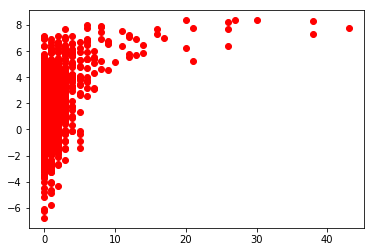

In [270]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[0], numpy.transpose(bslTrainY), 'ro')
plt.show()

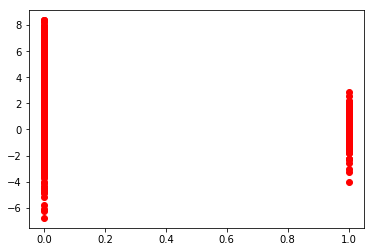

In [279]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[1], numpy.transpose(bslTrainY), 'ro')
plt.show()

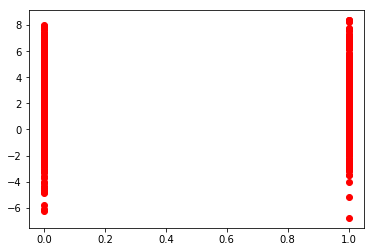

In [274]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[2], numpy.transpose(bslTrainY), 'ro')
plt.show()

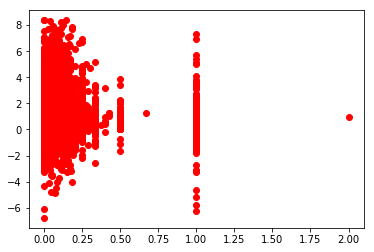

In [275]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[3], numpy.transpose(bslTrainY), 'ro')
plt.show()

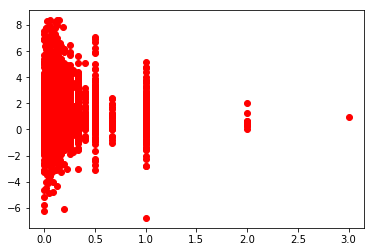

In [276]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[4], numpy.transpose(bslTrainY), 'ro')
plt.show()

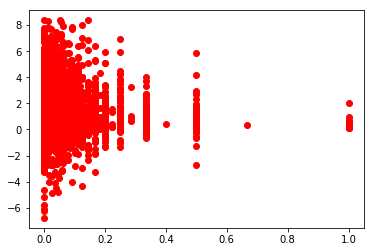

In [277]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[5], numpy.transpose(bslTrainY), 'ro')
plt.show()

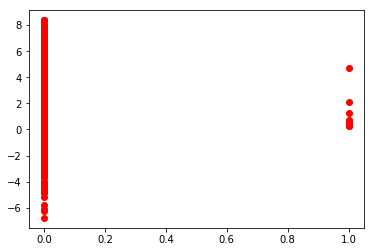

In [278]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[6], numpy.transpose(bslTrainY), 'ro')
plt.show()

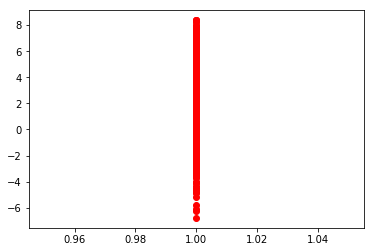

In [280]:
import matplotlib.pyplot as plt
plt.plot(numpy.transpose(bslTrainX)[7], numpy.transpose(bslTrainY), 'ro')
plt.show()